In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import random
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import noisereduce as nr

## Extracting MFFCs

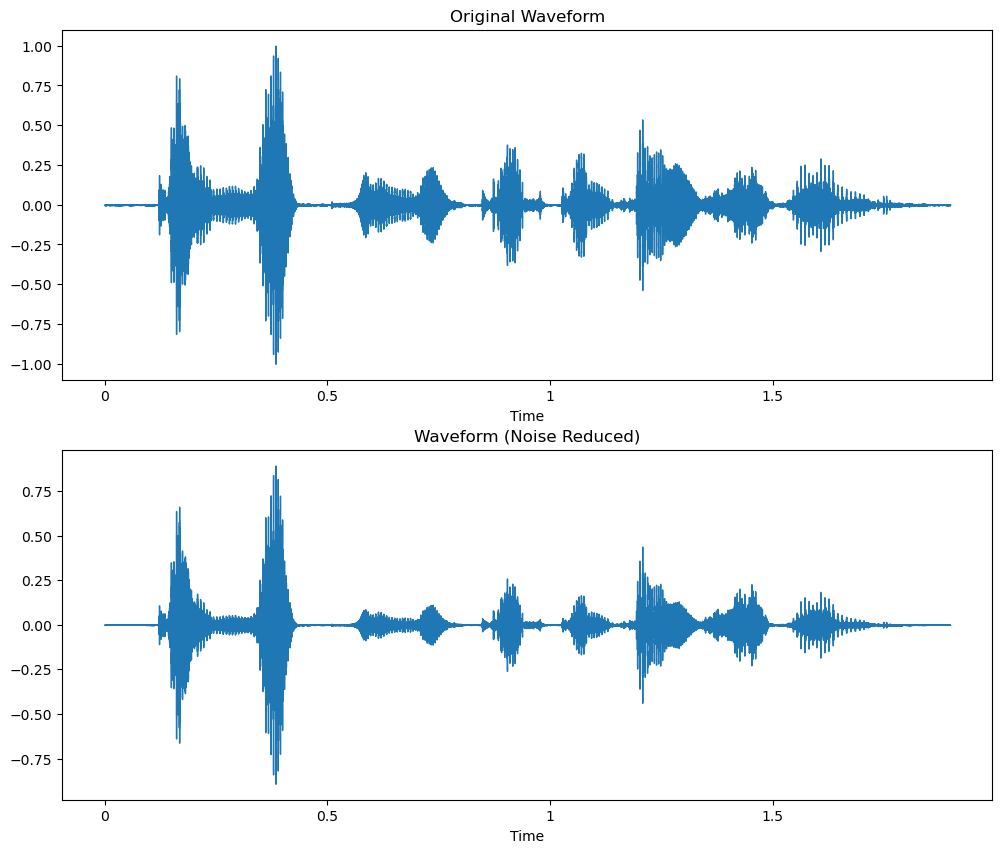

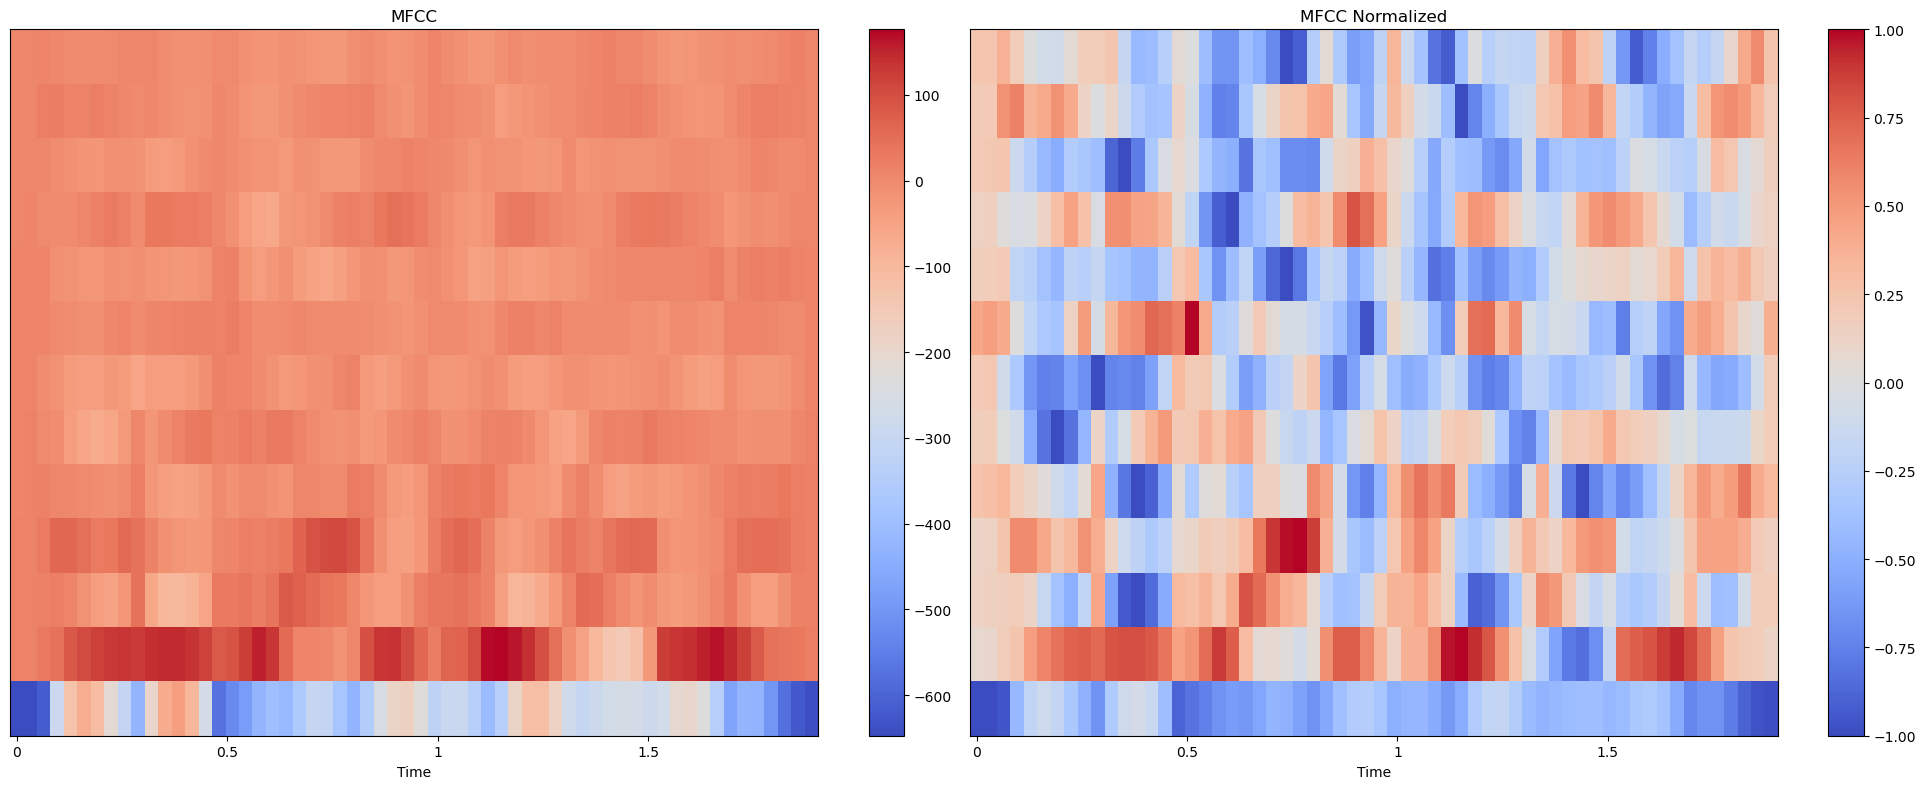

(13, 60)

In [102]:
# Example of MFCC extraction

w_ex, sr = librosa.load('data/wav/03a01Fa.wav', sr=None)
w_ex_noise_reduced = nr.reduce_noise(y=w_ex, sr=sr, prop_decrease=0.8)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
librosa.display.waveshow(w_ex, sr=sr)
plt.title('Original Waveform')

plt.subplot(2, 1, 2)
librosa.display.waveshow(w_ex_noise_reduced, sr=sr)
plt.title('Waveform (Noise Reduced)')

plt.savefig('noise_ex', dpi=300, bbox_inches='tight')
plt.show()

n_coeff = 13
MFCC_ex = librosa.feature.mfcc(y=w_ex_noise_reduced, sr=sr, n_mfcc=n_coeff)
MFCC_ex_normalized = librosa.util.normalize(MFCC_ex, axis=1)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
librosa.display.specshow(MFCC_ex, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

plt.subplot(1, 2, 2)
librosa.display.specshow(MFCC_ex_normalized, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC Normalized')
plt.tight_layout()

plt.savefig('MFCC_ex', dpi=300, bbox_inches='tight')
plt.show()

# plt.figure(figsize=(10, 6))
# librosa.display.specshow(MFCC_ex, sr=sr, x_axis='time')
# plt.colorbar()
# plt.title('MFCC')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 6))
# librosa.display.specshow(MFCC_ex_normalized, sr=sr, x_axis='time')
# plt.colorbar()
# plt.title('MFCC Normalized')
# plt.tight_layout()
# plt.show()

MFCC_ex.shape

In [32]:
emo_labels = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}

def get_label(file_name):
    label = file_name[5]
    return emo_labels[label]
    
def resizeMFCC(mfccs, target_steps):
    if mfccs.shape[1] < target_steps:
        padding = target_steps - mfccs.shape[1]
        mfccs_resized = np.pad(mfccs, ((0, 0), (0, padding)), mode='constant')
    elif mfccs.shape[1] > target_steps:
        mfccs_resized = mfccs[:, :target_steps]
    else:
        mfccs_resized = mfccs
    return mfccs_resized

In [36]:
n_coeff = 13
max_length = 150
labels = []
waveforms = []
MFCCs = []

MFCC_ex = librosa.feature.mfcc(y=w_ex_noise_reduced, sr=sr, n_mfcc=n_coeff)
MFCC_ex_normalized = librosa.util.normalize(MFCC_ex, axis=1)
w_ex_noise_reduced = nr.reduce_noise(y=w_ex, sr=sr, prop_decrease=0.8)

for file_name in os.listdir('data/wav'):
    label = get_label(file_name)
    file_path = os.path.join('data/wav', file_name)   
    w, sr = librosa.load(file_path, sr=sr)
    for i in range(3):
        rand1 = -3 + random.random() * 6
        w_pitch_shifted = librosa.effects.pitch_shift(w, sr=sr, n_steps=rand1)
        w_pitch_shifted = nr.reduce_noise(y=w_pitch_shifted, sr=sr, prop_decrease=0.8)
        MFCC_pitch_shifted = librosa.feature.mfcc(y=w_pitch_shifted, sr=sr, n_mfcc=n_coeff)
        MFCC_pitch_shifted = librosa.util.normalize(MFCC_pitch_shifted, axis=1)
        MFCC_pitch_shifted = resizeMFCC(MFCC_pitch_shifted, max_length)
        MFCCs.append(MFCC_pitch_shifted)
        labels.append(label)
            
        rand2 = 0.8 + random.random() * 0.4
        w_time_stretched = librosa.effects.time_stretch(w, rate=rand2)
        w_time_stretched = nr.reduce_noise(y=w_time_stretched, sr=sr, prop_decrease=0.8)
        MFCC_time_stretched = librosa.feature.mfcc(y=w_time_stretched, sr=sr, n_mfcc=n_coeff)
        MFCC_time_stretched = librosa.util.normalize(MFCC_time_stretched, axis=1)
        MFCC_time_stretched = resizeMFCC(MFCC_time_stretched, max_length)
        MFCCs.append(MFCC_time_stretched)
        labels.append(label)

    w = nr.reduce_noise(y=w, sr=sr, prop_decrease=0.8)
    MFCC_w = librosa.feature.mfcc(y=w, sr=sr, n_mfcc=n_coeff)
    MFCC_w = librosa.util.normalize(MFCC_w, axis=1)
    MFCC_w = resizeMFCC(MFCC_w, max_length)
    MFCCs.append(MFCC_w)
    labels.append(label)


In [42]:
len(MFCCs), len(labels)

(3745, 3745)

In [83]:
from tensorflow.keras.utils import to_categorical

y = np.array(labels)
num_classes = len(np.unique(y))
y = to_categorical(y)
print(y.shape)

X = np.array(MFCCs)
X = X[..., np.newaxis]
print(X.shape)

print(num_classes)

(3745, 7)
(3745, 13, 150, 1)
7


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2621, 13, 150, 1),
 (2621, 7),
 (562, 13, 150, 1),
 (562, 7),
 (562, 13, 150, 1),
 (562, 7))

In [89]:
from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.optimizers import Adam,SGD

model = models.Sequential()
model.add(Input(shape=(13, 150, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',  metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val))
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy}')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 11, 148, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 11, 148, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 74, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 72, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 72, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 1, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,143 (1.20 MB)

 Trainable params: 314,951 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.1720 - loss: 3.5424 - val_accuracy: 0.3043 - val_loss: 1.9101
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.3367 - loss: 1.8716 - val_accuracy: 0.3096 - val_loss: 1.8806
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4237 - loss: 1.5349 - val_accuracy: 0.3043 - val_loss: 1.8570
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.4586 - loss: 1.4072 - val_accuracy: 0.2384 - val_loss: 1.8422
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5003 - loss: 1.2913 - val_accuracy: 0.2046 - val_loss: 1.8352
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.5412 - loss: 1.1971 - val_accuracy: 0.2206 - val_loss: 1.8321
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5581 - loss: 1.1464 - val_accuracy: 0.2473 - val_loss: 1.8233
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6016 - loss: 1.0553 - val_accuracy: 0.

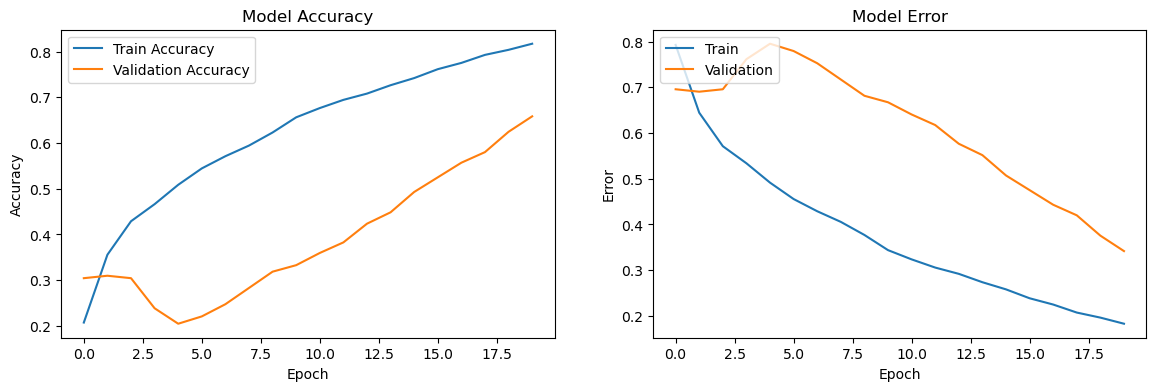

In [93]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

train_error = 1 - np.array(history.history['accuracy'])
val_error = 1 - np.array(history.history['val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(train_error, label='Train Error')
plt.plot(val_error, label='Validation Error')
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.savefig('EMO_cnn', dpi=300, bbox_inches='tight')
plt.show()

In [95]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6413 - loss: 1.0064


In [378]:
df = pd.DataFrame(waveforms)
df['label'] = labels

df.columns = [f'{i}' for i in range(max_length)] + ['label']

In [382]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,49991,49992,49993,49994,49995,49996,49997,49998,49999,label
0,0.000703,0.002744,0.003208,0.001250,0.000014,0.001231,0.002496,0.002128,0.001437,0.001101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.000709,0.002494,0.003362,0.002143,0.000363,0.000224,0.001621,0.002514,0.002160,0.001533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.000703,0.002730,0.003222,0.001299,0.000013,0.001166,0.002477,0.002167,0.001468,0.001107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.000736,0.002496,0.003361,0.002157,0.000394,0.000262,0.001646,0.002518,0.002164,0.001549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.000700,0.002659,0.003279,0.001546,0.000045,0.000846,0.002327,0.002345,0.001643,0.001178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [386]:
X = df.iloc[:, 1:].values
y = df.iloc[:, max_length].values.astype('uint8')
X.shape, y.shape

((3745, 50000), (3745,))